## [Link to GitHub Repository](https://github.com/linusghanadan/chesapeake-bay-nutrient-pollution-python)

## Context
This project was completed as a final project for my Statistics class, taken as part of my Master's program at UC Santa Barbara. I worked independently to find data, pose a statistical question, and carry out analysis using appropriate modeling techniques. Originally, this analysis was conducted in R (Link to R Code Repository), but I decided to reproduce this analysis to practice my Python skills working with large datasets and building statistical models with the statsmodels library.

## Question
Since the 2010 introduction of federal water quality requirements, what seasonal and non-seasonal trends are present for nitrogen and phosphorus concentrations in Chesapeake Bay tidal regions?

## Analysis summary
Proposed statistical question on how nutrient concentrations have changed since Clean Water Act protection measures (implemented in 2010) and found appropriate data for answering the question (used over 43,000 samples from the Bay’s tidal regions). Constructed two Seasonal-Trend using LOESS (STL) decomposition models to conduct time series analysis of nitrogen and phosphorus concentrations (selected length of seasons based on autocorrelation). For each pollutant, visualized model parameters comparatively. In addition, ran regressions to determine the proportion of variation attributable to seasonality and the 95% confidence interval for change in trend component over the 10-year period.

## Introduction
The Chesapeake Bay is the largest estuary in the United States, and the largest body of water that is regulated under the Clean Water Act [@us_environmental_protection_agency_chesapeake_2023]. Federal regulation pertaining to the Bay took decades to implement, and this is in large part because of the Bay’s large size and the many stakeholders involved. In the 1970s, the Bay was identified as one of the first areas in the world to have a marine dead zone, a phenomenon that literally suffocates aquatic life due to lack of oxygen in the water. Despite dead zones being identified in the 1970s, it was not until 2000 that the Bay was designated as an “impaired water” under the Clean Water Act. Then, it took another ten years, until 2010, for the EPA to take the next step of issuing Total Maximum Daily Load (TMDL) requirements, the regulatory action mandating water quality improvement.

Specifically, a TMDL is the maximum amount of a particular pollutant that a body of water can receive and still meet applicable water quality standards [@us_environmental_protection_agency_chesapeake_2023]. This maximum amount is calculated in pounds based on measurements taken at areas where pollution is likely to end up in the Bay. In their 2010 regulation, the EPA established TMDL requirements for nitrogen, phosphorus, and sediment. Nitrogen and phosphorus, referred to as nutrients because of their role in providing nutrition to many animals and plants, cause algal blooms, which cause marine dead zones through taking in dissolved oxygen and blocking sunlight. Sediment contributes to dead zones by blocking sunlight as well, leading it to also be included in the 2010 TMDL requirements.

This analysis will focus on nitrogen and phosphorus, the two pollutants responsible for algal blooms in the Chesapeake Bay. A 2022 study found that agricultural runoff was the largest source of nutrient pollution, accounting for 48% of nitrogen and 27% of phosphorus in the Chesapeake Bay [@chesapeake_progress_2025_nodate]. Both of these pollutants also get to the Bay as a result of urban and suburban runoff, wastewater treatment plants releasing treated water, and natural sources (e.g., runoff from forests, wetlands, etc.). In addition, about 25% of nitrogen that ends up in the Bay comes from air pollution that is originally emitted to the atmosphere by sources such as cars and factories [@burns_atmospheric_2021]. Through a process called atmospheric deposition, these nitrogen compounds react with other chemicals to become nitrous oxides, which can be deposited back to Earth’s surface through precipitation or as dry deposition.

Through conducting a time series analysis of post-2010 nitrogen and phosphorus concentration measurements, my goal is to better understand how concentrations have changed since the introduction of TMDL requirements. I’m also interested in the nature of any seasonality and whether the three time series components (i.e., seasonal, trend, and random) are consistent across both nitrogen and phosphorus.

## Data
Yearly water quality data on the Chesapeake Bay’s tidal and non-tidal regions going back to 1984 is publicly available on the Chesapeake Bay Program (CBP) DataHub [@chesapeake_bay_program_datahub_traditional_nodate]. Data is organized into either Tier 1, 2, or 3 depending on how it was collected. While Tier 1 and 2 data can be collected by any interested group, Tier 3 data is collected by monitoring stations overseen by experienced professionals. Only Tier 3 data can be used for governmental regulatory assessments.

For my analysis, I will be using 2010 to 2019 Tier 3 data collected at 143 different monitoring stations positioned throughout the Chesapeake Bay tidal regions, which includes the mainstem Bay and tributary components. Across the 10 years that we are looking at, we’ll have a total of 43,809 nitrogen observations and 43,590 phosphorus observations.

Below, we import the Python libraries used in this analysis. Then, we read in the yearly water quality data using their CBP DataHub URL. We also process the data by creating separate data.frames for total nitrogen and phosphorus measurements.

In [1]:
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics libraries
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.regression.linear_model import OLS

# Other libraries
import requests
from io import BytesIO

In [2]:
# Create a list of data URLs
excel_urls = [
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2019_CEDR_tidal_data_01jun21.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2018_CEDR_tidal_data_01jun21.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2017_CEDR_tidal_data_11oct18.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2016_CEDR_tidal_data_15jun17.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2015_CEDR_tidal_data_15jun17.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2014_CEDR_tidal_data_15jun17.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2013_CEDR_tidal_data_15jun17.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2012_CEDR_tidal_data_15jun17.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2011_CEDR_tidal_data_15jun17.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2010_CEDR_tidal_data_15jun17.xlsx'
]

# Create an empty list to store data frames
dfs = []

# Loop through each URL, read the Excel file directly into pandas, and append to list of data frames
for url in excel_urls:
    # Get the content of the Excel file
    response = requests.get(url)
    
    # Read the Excel file directly from the content
    wq_data = pd.read_excel(BytesIO(response.content), sheet_name=0)
    dfs.append(wq_data)

# Combine all data frames into a single data frame
wq_data_combined = pd.concat(dfs, ignore_index=True)

In [3]:
# Wrangle data for relevant column variables, filter for TN (total nitrogen), and remove Parameter column
nitr_data = wq_data_combined[["SampleDate", "Parameter", "MeasureValue", "Latitude", "Longitude"]]
nitr_data = nitr_data[nitr_data["Parameter"] == "TN"]
nitr_data.drop(columns=['Parameter'], inplace=True)

nitr_data.info()

# Wrangle data for relevant column variables, and filter for TP (total phosphorus)
phos_data = wq_data_combined[["SampleDate", "Parameter", "MeasureValue", "Latitude", "Longitude"]]
phos_data = phos_data[phos_data["Parameter"] == "TP"]
phos_data.drop(columns=['Parameter'], inplace=True)

phos_data.info()

# Remove from environment
del wq_data_combined


<class 'pandas.core.frame.DataFrame'>
Index: 43809 entries, 56 to 2484389
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   SampleDate    43809 non-null  datetime64[ns]
 1   MeasureValue  43809 non-null  float64       
 2   Latitude      43809 non-null  float64       
 3   Longitude     43809 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.7 MB
<class 'pandas.core.frame.DataFrame'>
Index: 43590 entries, 60 to 2484391
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   SampleDate    43590 non-null  datetime64[ns]
 1   MeasureValue  43590 non-null  float64       
 2   Latitude      43590 non-null  float64       
 3   Longitude     43590 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.7 MB


## Exploratory analysis
We'll start by briefly looking at average concentration by location using a heatmap (courtesy of the seaborn library).

/tmp/ipykernel_18/2516891936.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  nitr_heatmap_data = nitr_data_copy.pivot_table(index='Latitude Group', columns='Longitude Group', values='MeasureValue', aggfunc='mean')
/tmp/ipykernel_18/2516891936.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


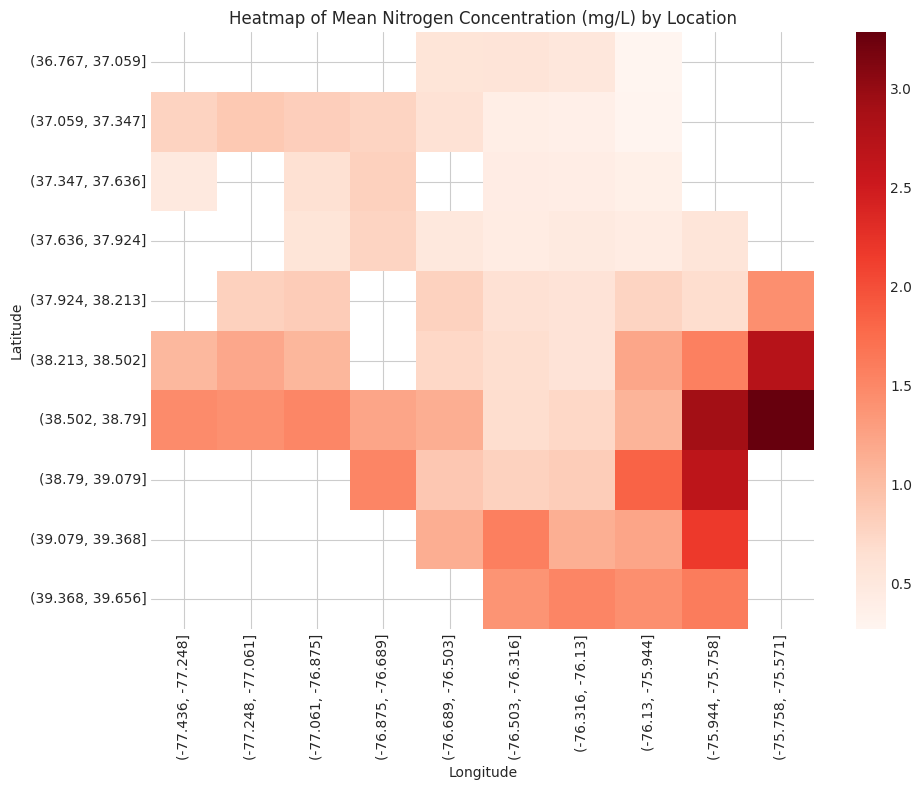

In [4]:
# Nitrogen

# Bin latitude and longitude into groups
nitr_data_copy = pd.DataFrame(nitr_data)
nitr_data_copy['Latitude Group'] = pd.cut(nitr_data['Latitude'], bins=10)
nitr_data_copy['Longitude Group'] = pd.cut(nitr_data['Longitude'], bins=10)

# Pivot the data to create a heatmap
nitr_heatmap_data = nitr_data_copy.pivot_table(index='Latitude Group', columns='Longitude Group', values='MeasureValue', aggfunc='mean')

# Remove from environment
del nitr_data_copy

# Initialize the figure
plt.figure(figsize=(10, 8))

# Set style
plt.style.use('seaborn-whitegrid')

# Plot heatmap
sns.heatmap(nitr_heatmap_data, cmap='Reds')

# Customize the plot
plt.title('Heatmap of Mean Nitrogen Concentration (mg/L) by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# Remove from environment
del nitr_heatmap_data

/tmp/ipykernel_18/190755117.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  phos_heatmap_data = phos_data_copy.pivot_table(index='Latitude Group', columns='Longitude Group', values='MeasureValue', aggfunc='mean')
/tmp/ipykernel_18/190755117.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


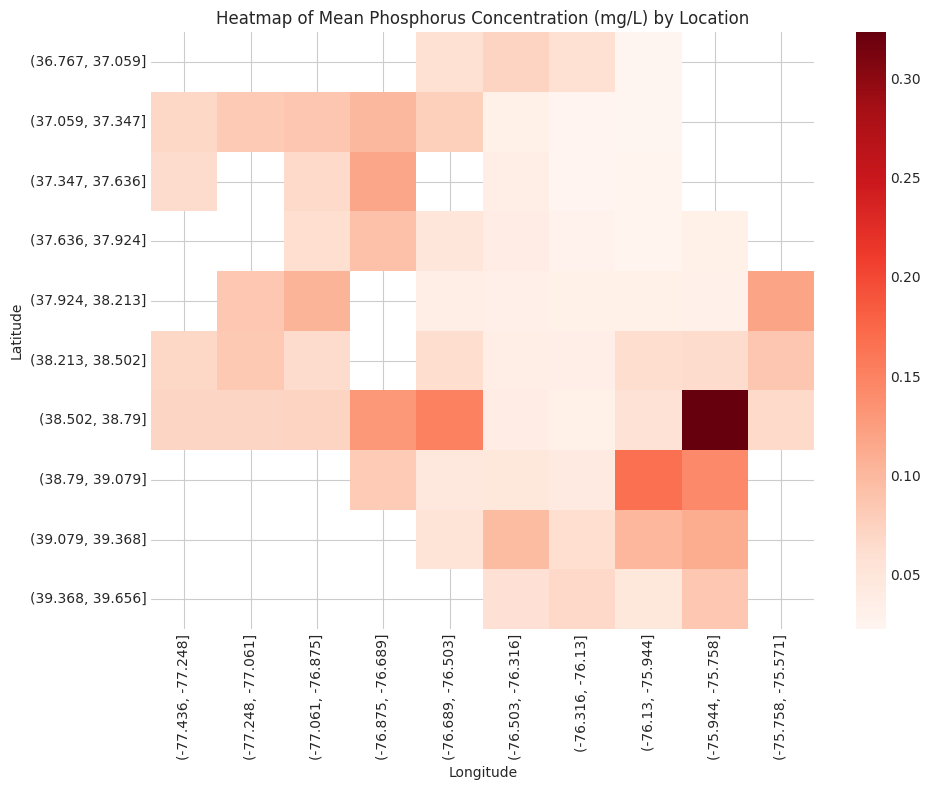

In [5]:
# Phosphorus

# Bin latitude and longitude into groups
phos_data_copy = pd.DataFrame(phos_data)
phos_data_copy['Latitude Group'] = pd.cut(phos_data['Latitude'], bins=10)
phos_data_copy['Longitude Group'] = pd.cut(phos_data['Longitude'], bins=10)

# Pivot the data to create a heatmap
phos_heatmap_data = phos_data_copy.pivot_table(index='Latitude Group', columns='Longitude Group', values='MeasureValue', aggfunc='mean')

# Remove from environment
del phos_data_copy

# Initialize the figure
plt.figure(figsize=(10, 8))

# Set style
plt.style.use('seaborn-whitegrid')

# Plot heatmap
sns.heatmap(phos_heatmap_data, cmap='Reds')

# Customize the plot
plt.title('Heatmap of Mean Phosphorus Concentration (mg/L) by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# Remove from environment
del phos_heatmap_data

Interestingly, nitrogen and phosphorus concentration are both generally higher in the southeast regions of the Chesapeake Bay.

Moving forward, we’ll start with our time series analysis by calculating moving averages for each year-month. We’ll plot these moving averages just to get a general idea of what types of trends we might be looking at.

/tmp/ipykernel_18/368804770.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  nitr_monthly_avg = nitr_data['MeasureValue'].resample('M').mean()


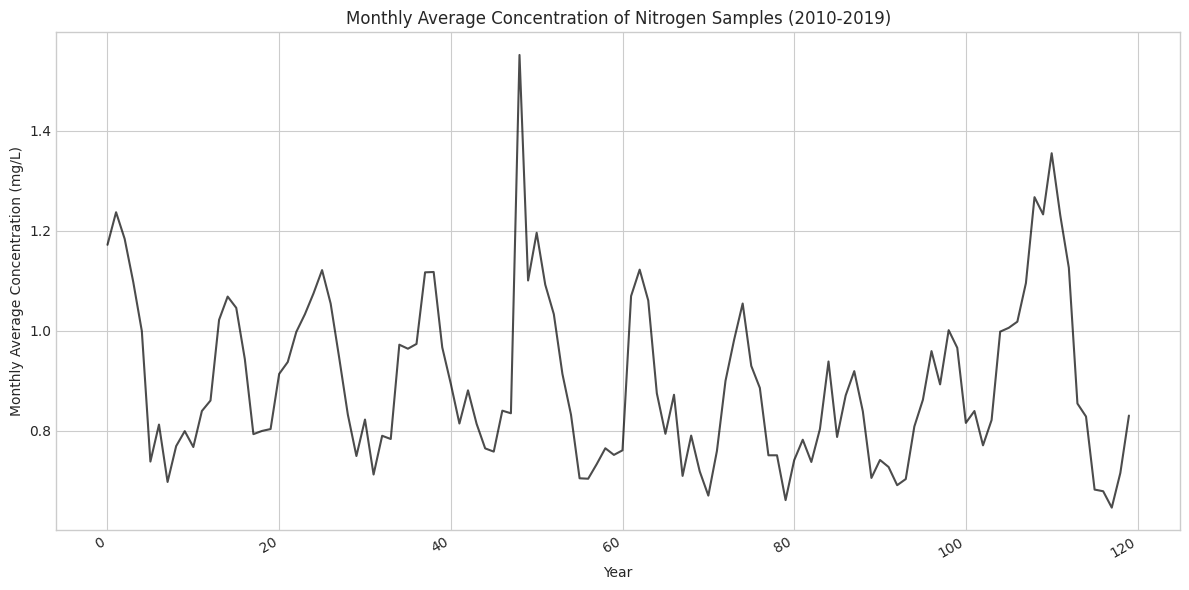

In [6]:
# Nitrogen

# Remove columns from the nitrogen data that are no longer needed
nitr_data.drop(columns=['Latitude', 'Longitude'], inplace=True)

# Convert 'SampleDate' to datetime
nitr_data['SampleDate'] = pd.to_datetime(nitr_data['SampleDate'])

# Set 'SampleDate' as the index
nitr_data.set_index('SampleDate', inplace=True)

# Resample to monthly frequency and calculate the mean for the 'MeasureValue' column
nitr_monthly_avg = nitr_data['MeasureValue'].resample('M').mean()

# Convert the result to a DataFrame
nitr_monthly_avg = nitr_monthly_avg.reset_index()

# Remove from environment
del nitr_data

# Initialize figure
plt.figure(figsize=(12, 6))

# Plot monthly average nitrogen data
plt.plot(nitr_monthly_avg.index, nitr_monthly_avg['MeasureValue'], color='black', alpha=0.7)

# Customize the plot
plt.title('Monthly Average Concentration of Nitrogen Samples (2010-2019)')
plt.xlabel('Year')
plt.ylabel('Monthly Average Concentration (mg/L)')

# Rotate and align tick labels
plt.gcf().autofmt_xdate()

# Use tight layout to ensure everything fits without overlapping
plt.tight_layout()

plt.show()

From this plot, there does appear to be a seasonal trend for nitrogen concentrations, but there is no clear non-seasonal trend. In addition, there is a notable spike in early 2014.

/tmp/ipykernel_18/3702329752.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  phos_monthly_avg = phos_data['MeasureValue'].resample('M').mean()


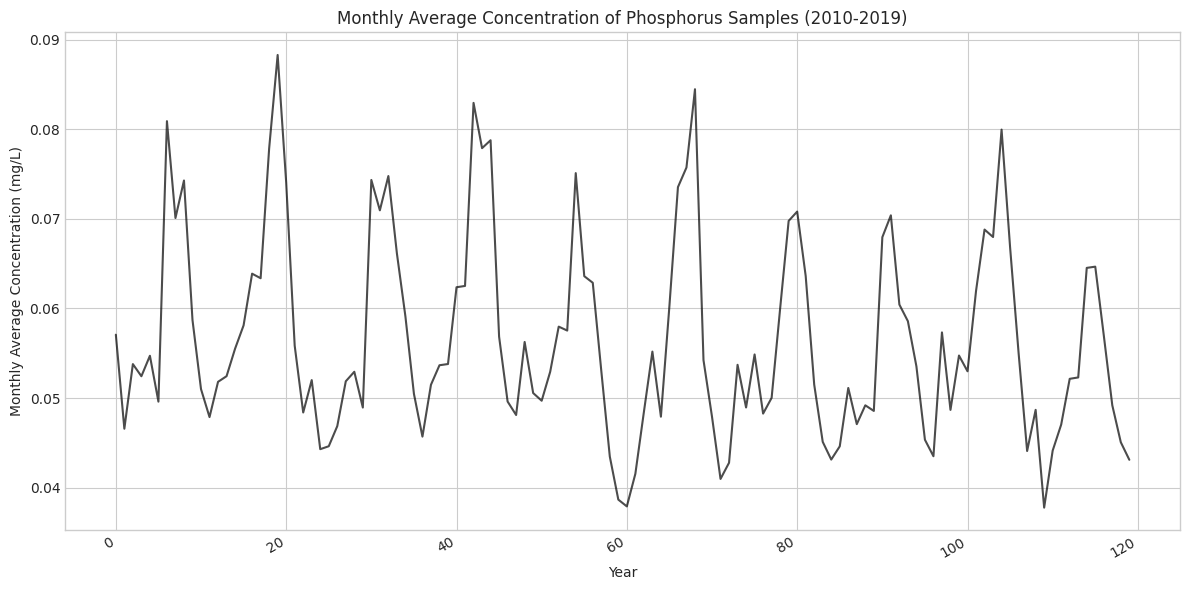

In [7]:
# Phosphorus

# Remove columns from the phosphorus data that are no longer needed
phos_data.drop(columns=['Latitude', 'Longitude'], inplace=True)

# Convert 'SampleDate' to datetime
phos_data['SampleDate'] = pd.to_datetime(phos_data['SampleDate'])

# Set 'SampleDate' as the index
phos_data.set_index('SampleDate', inplace=True)

# Resample to monthly frequency and calculate the mean for the 'MeasureValue' column
phos_monthly_avg = phos_data['MeasureValue'].resample('M').mean()

# Convert the result to a DataFrame
phos_monthly_avg = phos_monthly_avg.reset_index()

# Remove from environment
del phos_data

# Initialize figure
plt.figure(figsize=(12, 6))

# Plot monthly average phosphorus data
plt.plot(phos_monthly_avg.index, phos_monthly_avg['MeasureValue'], color='black', alpha=0.7)

# Customize the plot
plt.title('Monthly Average Concentration of Phosphorus Samples (2010-2019)')
plt.xlabel('Year')
plt.ylabel('Monthly Average Concentration (mg/L)')

# Rotate and align tick labels
plt.gcf().autofmt_xdate()

# Use tight layout to ensure everything fits without overlapping
plt.tight_layout()

plt.show()

Similar to the nitrogen plot, phosphorus also seems to exhibit a distinct seasonal trend. Again, it is unclear whether there is a non-seasonal trend.

## Methods
#### Autocorrelation function
The autocorrelation function calculates the correlation between the dependent variable at a given point in time and various time lags for this same variable. Thus, the autocorrelation function provides us with a tool that allows us to better understand any seasonal trends present in our data. This will be useful for us in subsequent steps of our time series analysis.

#### STL decomposition
As a core part of this time series analysis, I’ll be constructing a seasonal trend decomposition using locally estimated scatterplot smoothing (LOESS), which is often abbreviated as a STL decomposition model. STL allows us to separate our monthly average concentrations into three components: seasonal trend, non-seasonal trend, and remainder. Through plotting these components next to each other, we gain a more intuitive understanding of the underlying forces contributing to variation in our dependent variable, which in this case is the monthly average concentration.

As opposed to other decomposition methods, one thing that is particular to STL models is the ability to specify the length of a season. It can be helpful to adjust this input depending on our desired level of smoothing for the non-seasonal trend. We will use our results from the autocorrelation function to inform our chosen length of seasons. The autocorrelation function is useful in this context because it can tell us after how many lags we see a drop-off in correlation, indicating there is a drop in the significance of the seasonal trend.

## Results
#### Autocorrelation function

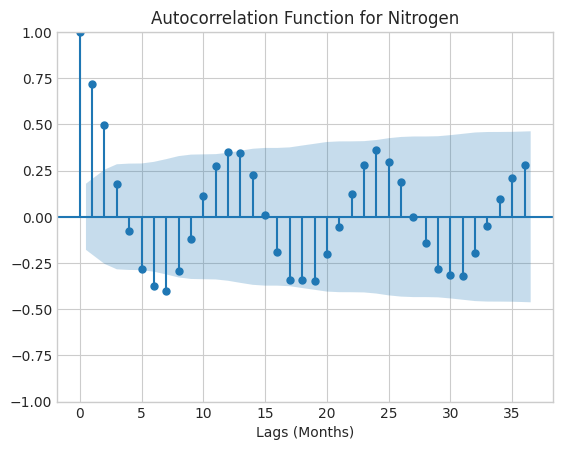

In [8]:
# Nitrogen

# Plot autocorrelation function for nitrogen with lags going back three years
sm.graphics.tsa.plot_acf(nitr_monthly_avg['MeasureValue'], lags=36, alpha=0.05)

plt.xlabel('Lags (Months)')
plt.title('Autocorrelation Function for Nitrogen')
plt.show()

Looking at this autocorrelation plot for nitrogen, I see that the t-16 lag is significant at the alpha equals 0.05 level, indicated by the black line extending beyond the blue dashed line. Meanwhile, the t-4 lag is not statistically significant. The rest of the lags remain the same or slightly decrease when comparing from the first and second year of lags. In the third year, there is a drop off in the t-28 lag compared to t-12, and there continues to be what seems like a marginal decrease in correlation across most lags. Considering all of this, I decided to set the seasonality of my STL model for nitrogen to 24 months.

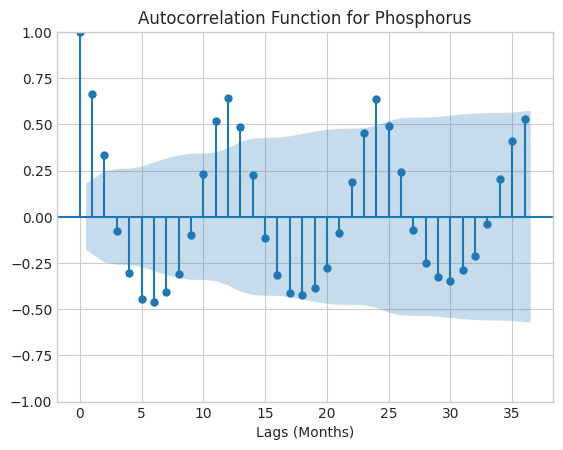

In [9]:
# Phosphorus

# Plot autocorrelation function for phosphorus with lags going back three years
sm.graphics.tsa.plot_acf(phos_monthly_avg['MeasureValue'], lags=36)

plt.xlabel('Lags (Months)')
plt.title('Autocorrelation Function for Phosphorus')
plt.show()

For phosphorus, there is a very consistent marginal decline for each set of lags over the course of the three years. This is good news for our STL because it means that the seasonal trend will be easier to separate from the non-seasonal trend. Like I did with nitrogen, I’m also going to use two-year seasons for phosphorus. Similar to the case with nitrogen, it seems to me like the drop-off in lag correlations from year two to year three is a bit larger than from year one to year two. This suggests that a two-year seasonal cycle will give us an informative non-seasonal trend component that is neither too eager nor too hesitant to categorize differences as non-seasonal trends.

#### STL decomposition

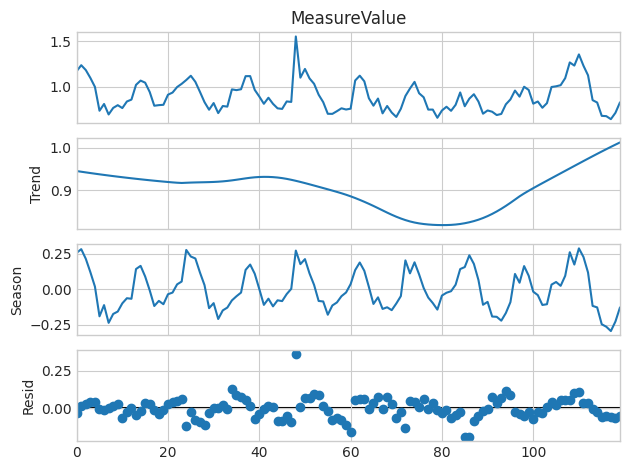

In [10]:
# Nitrogen

# Perform STL decomposition
nitr_stl = STL(nitr_monthly_avg['MeasureValue'], period=24)
nitr_decomp = nitr_stl.fit()

nitr_decomp.plot()

# Remove from environment
del nitr_stl

In this plot of the three STL components for nitrogen, it is still difficult to see a long-term trend, despite the line being fairly smooth. There does seem to be a slight downward trend until 2018. From 2018 to 2019, there is a clear increase, but this change is then offset by an equivalent decrease over the course of 2019 to 2020.

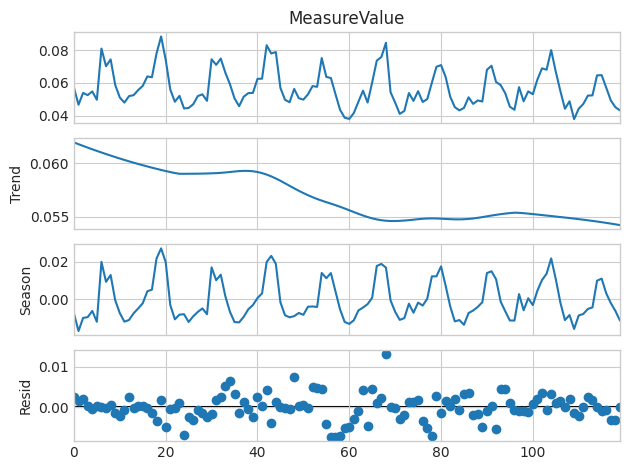

In [11]:
# Phosphorus

# Perform STL decomposition
phos_stl = STL(phos_monthly_avg['MeasureValue'], period=24)
phos_decomp = phos_stl.fit()

phos_decomp.plot()

# Remove from environment
del phos_stl

The STL plot for phosphorus does make it seem like there is a long-term downward trend, but it is difficult to tell how significant it is because of the long grey bar, which indicates it is least influential of the three components in our STL model.

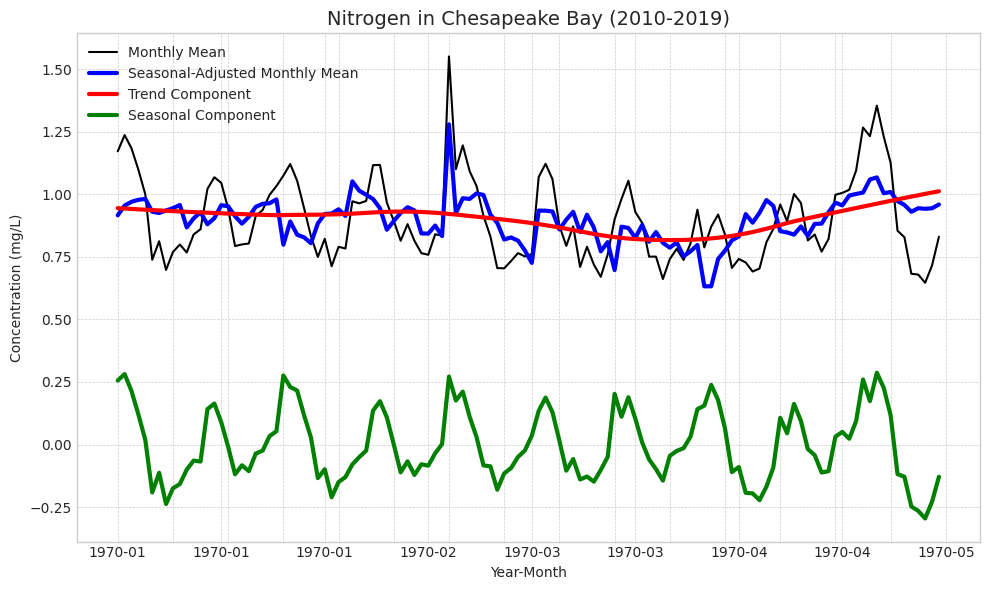

In [12]:
# Nitrogen

# Extract the components
nitr_trend = nitr_decomp.trend
nitr_seasonal = nitr_decomp.seasonal
nitr_resid = nitr_decomp.resid

# Remove from environment
del nitr_decomp

# Calculate the seasonally adjusted series
nitr_seasonally_adjusted = nitr_monthly_avg['MeasureValue'].values - nitr_seasonal

# Create the plot
plt.figure(figsize=(10, 6))

# Plot all components on the same axis
plt.plot(nitr_monthly_avg.index, nitr_monthly_avg['MeasureValue'].values, label='Monthly Mean', color='black')
plt.plot(nitr_monthly_avg.index, nitr_seasonally_adjusted, label='Seasonal-Adjusted Monthly Mean', color='blue', linewidth=3)
plt.plot(nitr_monthly_avg.index, nitr_trend, label='Trend Component', color='red', linewidth=3)
plt.plot(nitr_monthly_avg.index, nitr_seasonal, label='Seasonal Component', color='green', linewidth=3)

# Customize x-axis for date breaks
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Yearly major ticks
plt.gca().xaxis.set_minor_locator(plt.MaxNLocator(20))  # Half-yearly minor ticks
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

# Set labels and title
plt.xlabel('Year-Month')
plt.ylabel('Concentration (mg/L)')
plt.title('Nitrogen in Chesapeake Bay (2010-2019)', fontsize=14)

# Customize legend
plt.legend(loc='upper left')

# Add a grid and theme
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

# Remove from environment
del nitr_seasonally_adjusted

I decided to make this visualization to get a better idea of exactly how these components map on to each other. This plot seems to confirm the idea of negligible trend for nitrogen. Since the x-axis is labeled for each year here, it is also easier to see the seasonal trend. Each year, nitrogen concentrations increase sharply around December. They then peak around February to March, before decreasing substantially and reaching their minimum around July.

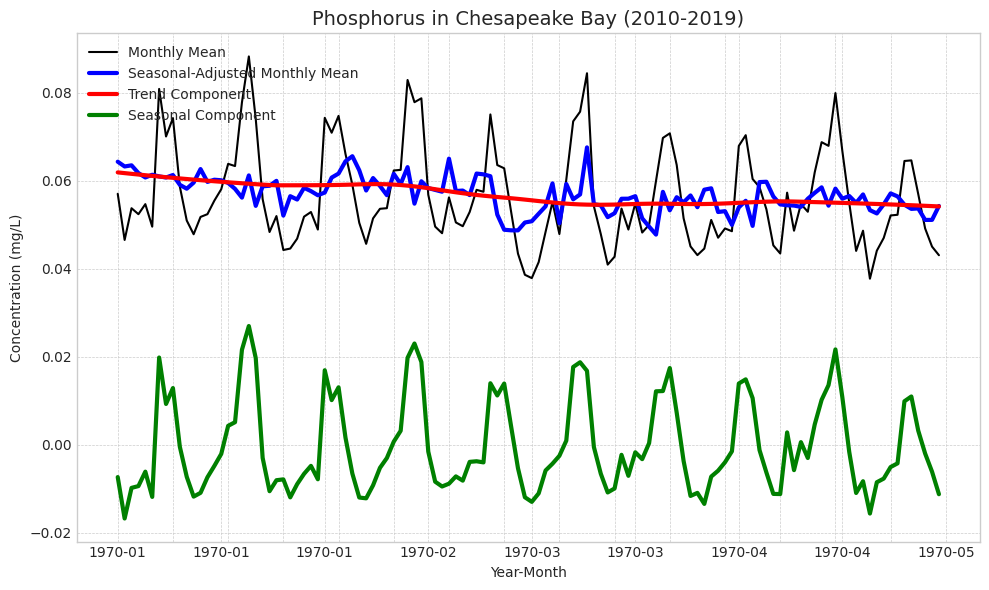

In [13]:
# Phosphorus

# Extract the components
phos_trend = phos_decomp.trend
phos_seasonal = phos_decomp.seasonal
phos_resid = phos_decomp.resid

# Remove from environment
del phos_decomp

# Calculate the seasonally adjusted series
phos_seasonally_adjusted = phos_monthly_avg['MeasureValue'].values - phos_seasonal

# Create the plot
plt.figure(figsize=(10, 6))

# Plot all components on the same axis
plt.plot(phos_monthly_avg.index, phos_monthly_avg['MeasureValue'].values, label='Monthly Mean', color='black')
plt.plot(nitr_monthly_avg.index, phos_seasonally_adjusted, label='Seasonal-Adjusted Monthly Mean', color='blue', linewidth=3)
plt.plot(phos_monthly_avg.index, phos_trend, label='Trend Component', color='red', linewidth=3)
plt.plot(phos_monthly_avg.index, phos_seasonal, label='Seasonal Component', color='green', linewidth=3)

# Customize x-axis for date breaks
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Yearly major ticks
plt.gca().xaxis.set_minor_locator(plt.MaxNLocator(20))  # Half-yearly minor ticks
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

# Set labels and title
plt.xlabel('Year-Month')
plt.ylabel('Concentration (mg/L)')
plt.title('Phosphorus in Chesapeake Bay (2010-2019)', fontsize=14)

# Customize legend
plt.legend(loc='upper left')

# Add a grid and theme
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

# Remove from environment
del phos_seasonally_adjusted


Our plot for phosphorus further supports the idea that there is a slight downward trend over the decade. If you independently trace the maximums or minimums, the line does seem to be moving downward at an oscillating but fairly consistent rate. Unlike nitrogen, phosphorus concentrations shoot up in the middle of the year around May, have a relatively flat peak lasting from June to August, and then shoot down at the end of Summer.

#### Linear regressions based on STL model parameters

In [14]:
# Nitrogen

# Run regression of season component on monthly average
X = sm.add_constant(nitr_seasonal)
y = nitr_monthly_avg['MeasureValue'].values
nitr_season_reg = OLS(y, X).fit()

# Print R-squared
r_squared = nitr_season_reg.rsquared
print(f"R-squared: {r_squared}")

R-squared: 0.7216759708762595


The adjusted R-squared of 0.55 indicates that seasonal trends can explain a bit over half (55%) of the variation in nitrogen monthly mean.

In [15]:
# Phosphorus

# Run regression of season component on monthly average
X = sm.add_constant(phos_seasonal)
y = phos_monthly_avg['MeasureValue'].values
phos_season_reg = OLS(y, X).fit()

# Print R-squared
r_squared = phos_season_reg.rsquared
print(f"R-squared: {r_squared}")

R-squared: 0.8716948739102784


For phosphorus, adjusted R-squared of this regression is 0.76, confirming our idea that seasonality is more pronounced with phosphorus.

In [16]:
# Nitrogen

# Run regression of trend component on monthly average
X = nitr_monthly_avg.index
y = nitr_trend
nitr_season_reg = OLS(y, X).fit()

# Get 95% confidence interval for 10 year trend
conf_int = nitr_season_reg.conf_int(alpha=0.05)
nitr_trend_conf_int = 120 * conf_int[1]

print(f"95% Confidence Interval for nitr_trend coefficient (mg/L): {nitr_trend_conf_int}")

# Get the 95% confidence interval for 10 year trend (in percent terms)
nitr_trend_conf_int = nitr_trend_conf_int / nitr_monthly_avg['MeasureValue'].values[0]

print(f"95% Confidence Interval for nitr_trend coefficient (%): {nitr_trend_conf_int}")

# Remove from environment
del nitr_monthly_avg
del nitr_trend

95% Confidence Interval for nitr_trend coefficient (mg/L): x1    1.499793
Name: 1, dtype: float64
95% Confidence Interval for nitr_trend coefficient (%): x1    1.279909
Name: 1, dtype: float64


In this linear regression, we look at the influence of year-month on our non-seasonal trend component for nitrogen. The regression output tells us that we can say at an alpha equals 0.01 significance level that the 10-year change in non-seasonal trend component was negative. However, the low adjusted R-squared also tells us that variation in year-month explains very little of the variation in trend component. Then, the first interval tells us that there is a 95% chance that the interval from -0.0028 mg/L to -0.0005 mg/L contains the true 10-year change in non-seasonal trend component. The second interval shows that this represents a -0.28% to -0.05% change as compared to the non-seasonal trend component in January 2010.

In [17]:
# Phosphorus

# Run regression of trend component on monthly average
X = phos_monthly_avg.index
y = phos_trend
phos_season_reg = OLS(y, X).fit()

# Get 95% confidence interval for 10 year trend
conf_int = phos_season_reg.conf_int(alpha=0.05)
phos_trend_conf_int = 120 * conf_int[1]

print(f"95% Confidence Interval for phos_trend coefficient (mg/L): {phos_trend_conf_int}")

# Get the 95% confidence interval for 10 year trend (in percent terms)
phos_trend_conf_int = phos_trend_conf_int / phos_monthly_avg['MeasureValue'].values[0]

print(f"95% Confidence Interval for phos_trend coefficient (%): {phos_trend_conf_int}")

95% Confidence Interval for phos_trend coefficient (mg/L): x1    0.093551
Name: 1, dtype: float64
95% Confidence Interval for phos_trend coefficient (%): x1    1.639039
Name: 1, dtype: float64


For phosphorus, the linear regression output tells us that we are confident at the alpha equals 0.01 level that the 10-year change in non-seasonal trend component was negative. It is also worth noting that the adjusted R-squared tells us that over half (56%) of the the variation in trend component can be explained by variation in year-month. Lastly, we find that there is a 95% chance that the interval between -0.00030 mg/L and -0.00022 mg/L contains the true 10-year change in non-seasonal trend component. This represents a -0.52% to -0.38% change as compared to the non-seasonal trend component in January 2010.

## Conclusion

My time series analysis suggests that seasonality plays a substantial role in contributing to variation in the monthly mean concentration of nitrogen and phosphorus in tidal regions of the Chesapeake Bay. For nitrogen, seasonal trends explained 55% of the variation in monthly means, and the relationship was even stronger for phosphorus, with seasonal trends explaining 76% of the variation. While the seasonal component for nitrogen was highest during Winter, the seasonal component for phosphorus was highest during Summer.

This analysis was also interested in any non-seasonal trend that has occurred since the introduction of TMDL requirements in 2010. For both nitrogen and phosphorus, we find evidence at an alpha level of 0.01 that the 10-year change in non-seasonal trend is negative. However, our confidence intervals suggest that, for both nutrient pollutants, these changes in trend represent a less than 1% decrease in concentration over the decade.

The main limitation of this analysis was that no form of spatial interpolation was employed to estimate concentrations across the tidal region based on the location of measurements. It would be interesting to compare such an analysis to what we did here, as any significant differences would imply that sampled areas are not spread throughout the region in a representative manner. Further analysis might also investigate what happened at the beginning of 2014 that could have led to the high spike in nitrogen levels at that time, in addition to factors that might have fueled the increase seen over the course of 2018.